In [1]:
import torch
import umap
import random
import numpy as np
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from tqdm import trange
from sklearn.model_selection import train_test_split

from models.GraphESN import GraphESN

from DMD.dmd import KANN

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = TUDataset(root='/ESGNN/data/MUTAG', name='MUTAG')

In [3]:
len(dataset)

188

In [4]:
dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

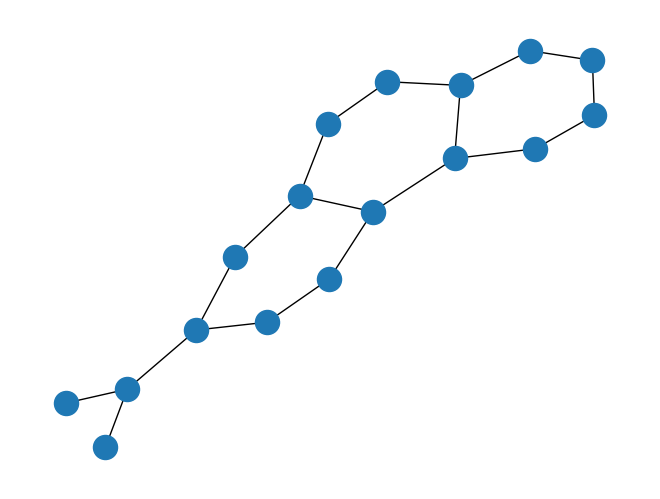

In [3]:
edge_index = dataset[0]['edge_index']
x = dataset[0]['x']
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [9]:
dataset[0]['y']

tensor([1])

In [3]:
model = GraphESN(input_size=7,
                hidden_size=286,
                steps=52,
                input_scaling=0.26,
                num_layers=1,
                leaking_rate=0.51,
                spectral_radius=3.16,
                density=0.86,
                activation='self_norm',
                alpha_decay=False)


In [17]:
embs = []
for g in dataset:
    embs.append(model(g['x'], g['edge_index']).mean(dim=0))
embs = torch.stack(embs).to(device)

torch.save(embs, 'GESN/embeddings_mutag.pt')

In [22]:
embs = torch.load('GESN/embeddings_mutag.pt')

In [5]:
embs.shape

torch.Size([188, 286])

In [42]:
states = []
for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim
    states.append(state.cpu())

norm = []

for s in states:
    norm.append(torch.linalg.vector_norm(s[:,:-1,:]-s[:,1:,:], dim=(0,2)))

norm = torch.stack(norm)

m_norm = norm.mean(dim=0)
s_norm = norm.std(dim=0)

In [25]:
state.shape

torch.Size([1, 52, 4576])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


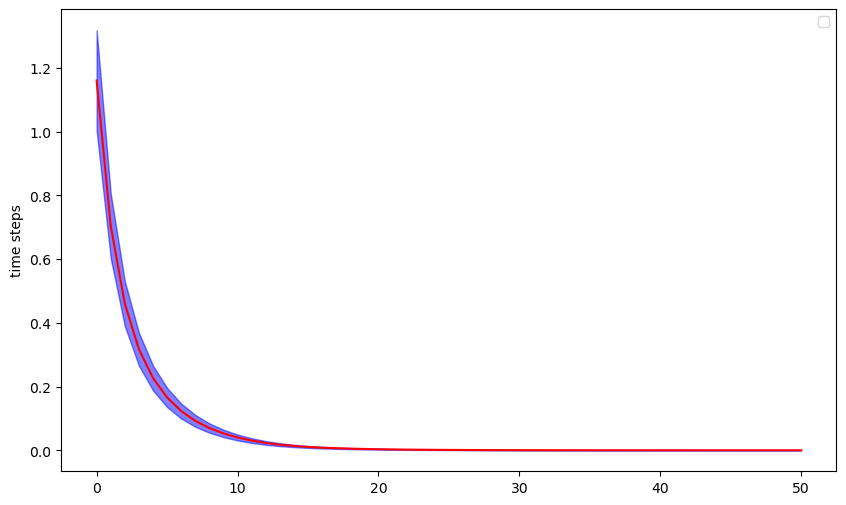

In [24]:
plt.figure(figsize=(10,6))
t = np.linspace(0, norm.shape[1]-1, norm.shape[1])
plt.plot(t, m_norm, color='r')
plt.fill_between(t, m_norm-s_norm, m_norm+s_norm, color='b', alpha=0.5)
plt.ylabel('time steps')
plt.legend()
plt.show()

In [6]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(embs.cpu())

Text(0.5, 1.0, 'UMAP projection')

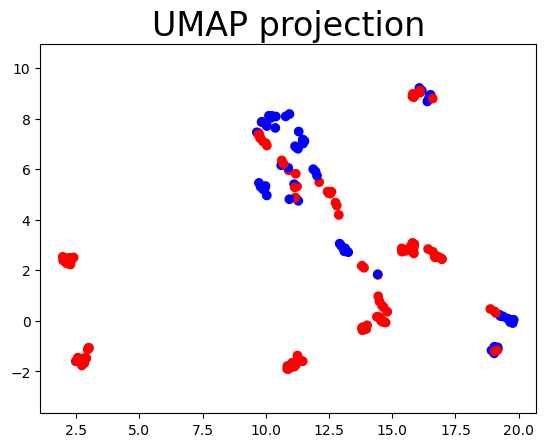

In [7]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=['b' if x['y']==0 else 'r' for x in dataset])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [112]:
check = 0
for i in range(len(dataset)):
    check += dataset[i]['y']

In [114]:
check / 188

tensor([0.6649])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(embs, dataset.y, test_size=0.3, random_state=seed)

In [10]:
y_test.sum() / y_test.shape[0]

tensor(0.6842)

In [9]:
classifier = torch.nn.Sequential(
    torch.nn.Linear(model.hidden_size, 2)
    ).to(device)

In [10]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.008)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 500
classifier.train()
losses, loss_e = [], []

for epoch in trange(epochs):
    for x, y in zip(X_train, y_train):
        out = classifier(x)
        optimizer.zero_grad()
        loss = loss_fn(out, y.type(torch.LongTensor).squeeze().to(device))
        loss.backward()
        optimizer.step()
        loss_e.append(loss.clone().detach())
    losses.append(torch.tensor(loss_e).mean())

100%|██████████| 500/500 [08:10<00:00,  1.02it/s]


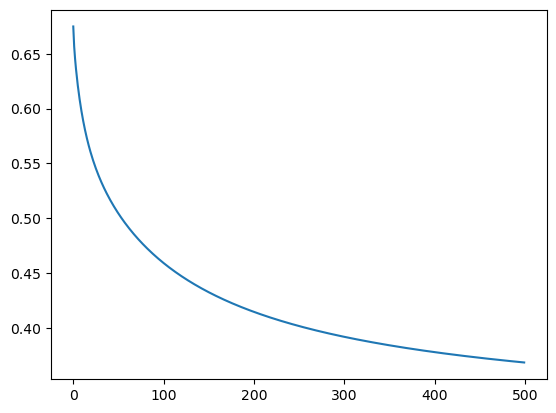

In [11]:
plt.plot(torch.tensor(losses).detach().cpu().numpy())

In [12]:
classifier.eval()
test_acc = (classifier(X_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(test_acc)

tensor(0.9298)


## Fit Koopman operator: linear terms only

In [39]:
koops = []
dim_red = 5
method = "TruncatedSVD"

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    koops.append(C.flatten())

koops = torch.from_numpy(np.stack(koops)).to(device)

In [6]:
koops.shape

torch.Size([188, 25])

In [7]:
torch.save(koops, f"KOP/{method}_{dim_red}.pt")

### Train classifier on Koopman operator

In [119]:
K_train, K_test, y_train, y_test = train_test_split(koops, dataset.y, test_size=0.3, random_state=seed)

In [120]:
state_classifier = torch.nn.Sequential(
    torch.nn.Linear(koops.shape[1], 2)
    ).to(device)

state_optimizer = torch.optim.Adam(state_classifier.parameters(), lr=0.00157)
loss_fn2 = torch.nn.CrossEntropyLoss()
epochs = 500
state_classifier.train()
losses2, loss_e2 = [], []

for epoch in trange(epochs):
    for k, y in zip(K_train, y_train):
        out = state_classifier(k)
        state_optimizer.zero_grad()
        loss2 = loss_fn2(out, y.type(torch.LongTensor).squeeze().to(device))
        loss2.backward()
        state_optimizer.step()
        loss_e2.append(loss2.clone().detach())
    losses2.append(torch.tensor(loss_e2).mean())

100%|██████████| 500/500 [08:13<00:00,  1.01it/s]


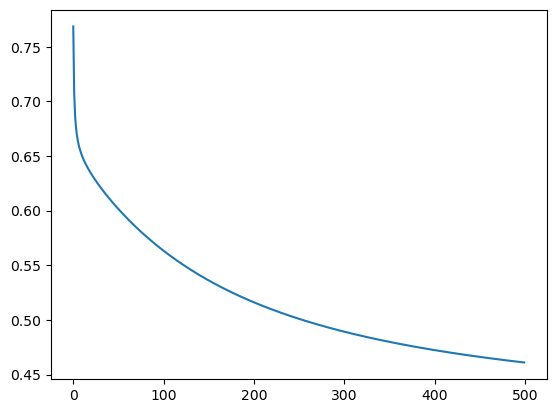

In [121]:
plt.plot(torch.tensor(losses2).detach().cpu().numpy())

In [122]:
state_classifier.eval()

state_test_acc = (state_classifier(K_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(f"Test accuracy: {state_test_acc}")

Test accuracy: 0.859649121761322


## Fit Koopman operator: quadratic terms

In [32]:
q_koops = []
dim_red = 5
method = "TruncatedSVD"

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0)
    state = torch.cat([state, state**2], dim=-1)

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method)    # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    q_koops.append(C.flatten())

q_koops = torch.from_numpy(np.stack(q_koops)).to(device)

In [33]:
q_koops.shape

torch.Size([188, 25])

In [34]:
torch.save(q_koops, f"KOP/quadr_{method}_{dim_red}.pt")

### Train classifier on Koopman operator (quadratic)

In [13]:
K_train, K_test, y_train, y_test = train_test_split(q_koops, dataset.y, test_size=0.3, random_state=seed)

100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


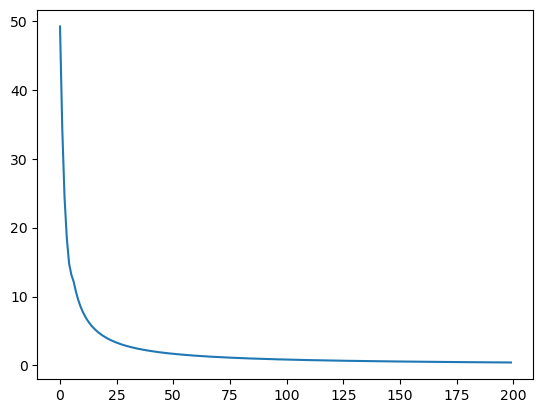

In [15]:
state_classifier = torch.nn.Sequential(
    torch.nn.Linear(q_koops.shape[1], 2)
    ).to(device)

state_optimizer = torch.optim.Adam(state_classifier.parameters(), lr=0.019)
loss_fn2 = torch.nn.CrossEntropyLoss()
epochs = 200
state_classifier.train()
losses2, loss_e2 = [], []

for epoch in trange(epochs):
    for k, y in zip(K_train, y_train):
        out = state_classifier(k)
        state_optimizer.zero_grad()
        loss2 = loss_fn2(out, y.type(torch.LongTensor).squeeze().to(device))
        loss2.backward()
        state_optimizer.step()
        loss_e2.append(loss2.clone().detach())
    losses2.append(torch.tensor(loss_e2).mean())

plt.plot(torch.tensor(losses2).detach().cpu().numpy())

In [16]:
state_classifier.eval()

state_test_acc = (state_classifier(K_test).cpu().argmax(dim=-1) == y_test).sum()/len(y_test)

print(f"Test accuracy: {state_test_acc}")

Test accuracy: 0.7719298005104065


# Explainability?

Difference between trajectory of (compressed) states and reconstruction of states via Koopman

In [60]:
dim_red = 5
method = "TruncatedSVD"
rec_traj = []
traj = []

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    traj.append(torch.from_numpy(kann_.Zp.squeeze()))
    rec_traj.append(torch.from_numpy(np.stack([C**n @ kann_.Zp.squeeze()[0,] for n in range(5)])))

In [65]:
norm = []
for i in range(len(traj)):
    norm.append(torch.linalg.vector_norm(traj[i]-rec_traj[i], dim=0))
norm = torch.stack(norm)
norm_m = norm.mean(dim=0)
norm_s = norm.std(dim=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


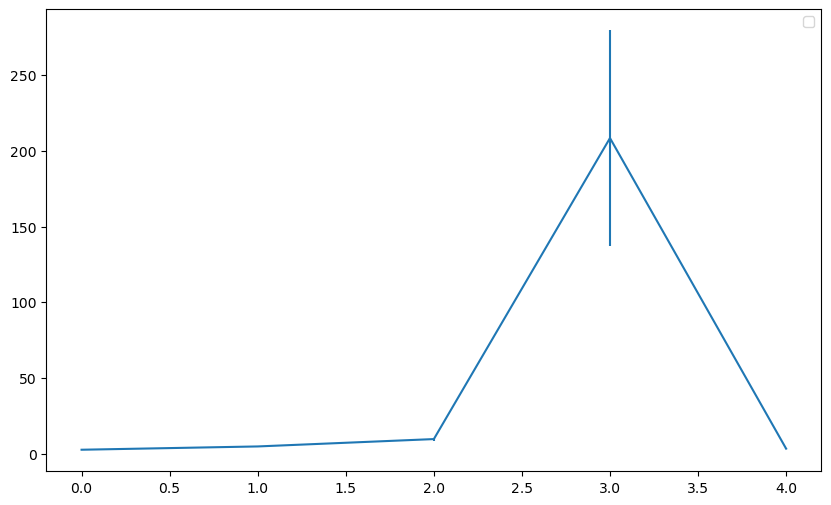

In [138]:
plt.figure(figsize=(10,6))
t = np.linspace(0, norm.shape[1]-1, norm.shape[1])
plt.errorbar(t, norm_m, yerr=norm_s)
plt.legend()
plt.show()

## Spectrum

Histogram of the spectrum

In [85]:
eigens, abs_eigens = [], []

for g in dataset:
    _ = model(g['x'], g['edge_index'])
    state = model.states
    state = torch.stack(state[1:], dim=1)
    state = torch.cat([state[k,:5,:] for k in range(state.shape[0])], dim=-1)
    state = state.unsqueeze(dim=0) # add batch dim

    # compute Koopman operator
    kann_ = KANN(state.cpu(), k=dim_red, emb=method) # serve perché hanno dimensioni diverse (nodi diversi)
                                                        # k <= steps
    C = kann_.compute_KOP()
    D, _ = np.linalg.eig(C)
    eigens.append(D)
    abs_eigens.append(np.absolute(D))

eigens = np.concatenate(eigens)
abs_eigens = np.concatenate(abs_eigens)

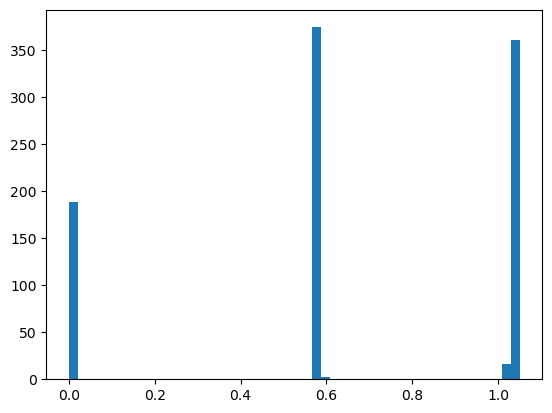

In [86]:
plt.hist(abs_eigens, bins=50)
plt.show()

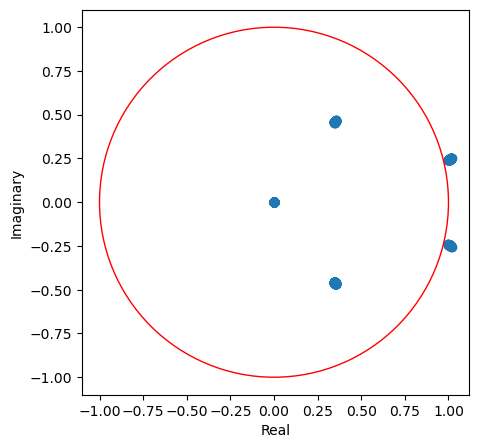

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(eigens.real, eigens.imag)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show() 

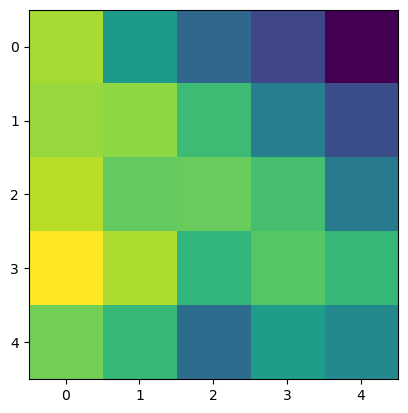

In [83]:
plt.imshow(np.log(np.abs(C)))

## Project on input

- perform SVD on states
- you get new states Zp with smaller dimensions
- find Koopman operator C that approximates Zp dynamics

In [88]:
# compute Koopman operator
C = kann_.compute_KOP() # last graph
D, V = np.linalg.eig(C)
U = np.linalg.inv(V)

In [89]:
np.allclose(C,(V @ np.diag(D) @ U)) # it should return True

True

In [90]:
kann_.Zp.shape

(1, 5, 5)

In [104]:
z = np.stack([C**n @ kann_.Zp.squeeze()[0,] for n in range(5)]) # reconstructed compressed states

Let's project states newZp onto the two most important eigenvectors

In [93]:
np.absolute(D)

array([1.0381122e+00, 1.0381122e+00, 5.7983375e-01, 5.7983375e-01,
       2.0944906e-09], dtype=float32)

In [107]:
scal0 = V[:,0].T @ z.T # scalar product with eigenvector
scal1 = V[:,1].T @ z.T # scalar product with eigenvector
proj = np.stack([V[:,0]*scal0[s] + V[:,1]*scal1[s] for s in range(len(scal0))]) # projection on eigenvector
proj = proj[np.newaxis, :, :] # add batch dim

In [126]:
proj.shape # batch, time steps, dim

(1, 5, 5)

In [ ]:
# Find output?
# state_classifier(torch.from_numpy(proj[:,-1,:]).type(torch.DoubleTensor).cuda())

Then we can recover the original sequence of states

In [111]:
recov = kann_.recover_states(proj.real, kann_.k)

In [113]:
recov.shape

(1, 5, 4576)

In [116]:
# recover the right shape
new_states = np.stack([recov.squeeze()[:,k*model.hidden_size:(k+1)*model.hidden_size] for k in range(recov.shape[-1]//model.hidden_size)], axis=1)
new_states = torch.tensor(new_states)

In [125]:
new_states.shape

torch.Size([5, 16, 286])

Can we plot the states back to the original graph?

In [131]:
imp = torch.softmax(torch.sum(new_states[-1,:,:],dim=-1),dim=0)
print(imp)

tensor([6.1498e-33, 7.8969e-33, 1.1976e-29, 8.1858e-02, 1.4503e-28, 8.1861e-02,
        5.7052e-27, 6.1425e-27, 3.5323e-08, 1.4194e-21, 8.3271e-01, 3.5715e-03,
        2.5432e-27, 1.0191e-14, 0.0000e+00, 0.0000e+00])


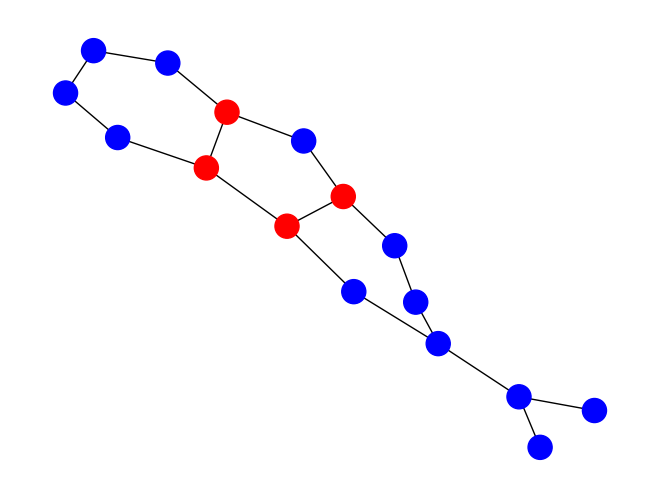

In [137]:
edge_index = dataset[-1]['edge_index'].cpu()
x = dataset[-1]['x'].cpu()
colors = ['r' if n>=0.001 else 'b' for n in imp]
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_color=colors)